# Code to generate TensorFlow models for predicting mean MFE and stdev based on nucleotide content.





## Use the right version of TensorFlow

The following hidden code cell ensures that the Colab will run on TensorFlow 2.X, which is the most recent version of TensorFlow:

In [17]:
#@title Run this Colab on TensorFlow 2.x
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Import relevant modules

The following cell imports the packages that the program requires:

In [15]:
import io
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.keras.metrics import Metric
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

%matplotlib inline
pd.options.display.float_format = "{:.1f}".format


In [16]:
print(tf.__version__)

2.8.2


## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds an empty model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 


In [18]:
def normalizer(shape): 
  preprocessing.Normalization(input_shape=shape)



In [19]:
#@title Define custom functions
def build_model(my_learning_rate, units, shape):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential. 
  # A sequential model contains one or more layers.
  model = tf.keras.models.Sequential()
  
  # Add normalization layer
  model.add(preprocessing.Normalization(input_shape=shape))

  # Add hidden non-linear layers
  model.add(tf.keras.layers.Dense(units=64, input_shape=shape, activation="relu"))
  model.add(tf.keras.layers.Dense(units=64, input_shape=shape, activation="sigmoid"))  
  
  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer. 
  model.add(tf.keras.layers.Dense(units=units, 
                                  input_shape=shape))
 
  # Compile the model topography into code that 
  # TensorFlow can efficiently execute. Configure 
  # training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the feature values and the label values to the 
  # model. The model will train for the specified number 
  # of epochs, gradually learning how the feature values
  # relate to the label values. 
  history = model.fit(x=feature,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the 
  # rest of history.
  epochs = history.epoch
  
  # Gather the history (a snapshot) of each epoch.
  hist = pd.DataFrame(history.history)

  # Specifically gather the model's root mean 
  #squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse



def get_gc_content(frag):
    ###Ensure frag is string
    frag = str(frag)
    if 'C' and 'G' in frag:
      A_count = frag.count("A")+frag.count("a")
      G_count = frag.count("G")+frag.count("g")
      C_count = frag.count("C")+frag.count("c")
      T_count = frag.count("T")+frag.count("t")+frag.count("U")+frag.count("u")
      gc_content = round(float(G_count+C_count)/float(A_count+T_count+G_count+C_count),5)
    else:
      gc_content = 0
      
    return gc_content

def get_cg_ratio(frag):
    frag = str(frag)
    if 'C' and 'G' in frag:
      A_count = frag.count("A")+frag.count("a")
      G_count = frag.count("G")+frag.count("g")
      C_count = frag.count("C")+frag.count("c")
      T_count = frag.count("T")+frag.count("t")+frag.count("U")+frag.count("u")
      cg_ratio = C_count/(C_count+G_count)
    else:
      cg_ratio = 0

    return cg_ratio

def get_au_ratio(frag):
    frag = str(frag)
    if 'A' and 'U' in frag:
      A_count = frag.count("A")+frag.count("a")
      G_count = frag.count("G")+frag.count("g")
      C_count = frag.count("C")+frag.count("c")
      T_count = frag.count("T")+frag.count("t")+frag.count("U")+frag.count("u")
      au_ratio = A_count/(A_count+T_count)
    else:
      au_ratio = 0

    return au_ratio


def get_di_freqs(frag):
    ### code taken from https://pythonforbiologists.com/dictionaries
    frag = str(frag)
    frag_list = [frag[i:i+2] for i in range(0, len(frag))]
    dinucleotides = ['AA','AU','AG','AC',
                     'UA','UU','UG','UC',
                     'GA','GU','GG','GC',
                     'CA','CU','CG','CC']
    all_counts = []
    for dinucleotide in dinucleotides:
        count = frag_list.count(dinucleotide)
        #print("count is " + str(count) + " for " + dinucleotide)
        all_counts.append(count/(len(frag)-1))

    return(all_counts)

def get_dinucleotide_counts(frag):
    ### code taken from https://pythonforbiologists.com/dictionaries
    frag = str(frag)
    frag_list = [frag[i:i+2] for i in range(0, len(frag))]
    print(frag_list)
    dinucleotides = ['AA','AU','AG','AC',
                     'UA','UU','UG','UC',
                     'GA','GU','GG','GC',
                     'CA','CU','CG','CC']
    all_counts = []
    for dinucleotide in dinucleotides:
        count = frag_list.count(dinucleotide)
        #print("count is " + str(count) + " for " + dinucleotide)
        all_counts.append(count)

    return(all_counts)


## Define plotting functions

We're using a popular Python library called [Matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) to create the following two plots:

*  a plot of the feature values vs. the label values, and a line showing the output of the trained model.
*  a [loss curve](https://developers.google.com/machine-learning/glossary/#loss_curve).

In [20]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against the training feature and label."""

  # Label the axes.
  plt.xlabel("feature")
  plt.ylabel("label")

  # Plot the feature values vs. label values.
  plt.scatter(feature, label)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = my_feature[-1]
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


## Load the dataset


Import the full training data set (as a pandas dataframe). Direct links to the datasets used are provided, but your own data can be uploaded via google drive, github, or local filesystem. 

In [ ]:
# If needed, this cell allows upload of local files for training/testing
# Uncomment (remove the hashtags) from the following two lines then run cell
# from google.colab import files
# uploaded = files.upload()

In [29]:
# Load training set from RNAStructuromeDB
training_df = pd.read_csv('https://structurome.bb.iastate.edu/files/download/trainingset.txt.gz')


In [22]:
# Load test set from RNAStructuromeDB
test_df = pd.read_csv('https://structurome.bb.iastate.edu/files/download/testset.rnacentral.20-200.all_.svm_data.csv__0.gz')


Check the data structure using "dataframe.describe"

In [23]:
test_df.describe()

,length,GC%,CGratio,AUratio,MFE,AA,AU,AG,AC,UA,...,GG,GC,CA,CU,CG,CC,MonoMFE,mono_z,DiMFE,di_z
count,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729592.0,5729592.0,...,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0
mean,85.1,0.5,0.5,0.5,-26.7,0.1,0.1,0.1,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.1,-20.8,-0.0,-21.5,-0.0
std,40.6,0.1,0.1,0.1,17.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.3,1.0,13.6,1.0
min,20.0,0.0,0.0,0.0,-221.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-118.5,-10.0,-140.0,-10.0
25%,66.0,0.4,0.4,0.4,-35.4,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-27.1,-0.6,-27.9,-0.6
50%,74.0,0.5,0.5,0.5,-25.7,0.1,0.1,0.1,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.1,-20.0,0.1,-21.0,0.1
75%,107.0,0.6,0.5,0.5,-14.1,0.1,0.1,0.1,0.1,0.0,...,0.1,0.1,0.1,0.1,0.1,0.1,-10.9,0.7,-11.5,0.7
max,200.0,1.0,1.0,1.0,0.0,1.0,0.5,0.5,0.5,0.0,...,1.0,0.4,0.5,0.5,0.3,1.0,0.0,4.4,0.0,4.0


Rename columns (to ensure compatibility with later functions)

In [24]:
test_df.columns =["Length", "GCpercent","CGratio", "AUratio", "MFE", "AA","AU","AG","AC","UA","UU","UG","UC","GA","GU","GG","GC","CA","CU","CG", "CC", "MonoMFE", "mono_z", "DiMFE", "di_z"]

Ensure values are numeric

In [25]:
test_df.apply(pd.to_numeric)

,Length,GCpercent,CGratio,AUratio,MFE,AA,AU,AG,AC,UA,...,GG,GC,CA,CU,CG,CC,MonoMFE,mono_z,DiMFE,di_z
0,200,0.6,0.4,0.6,-59.2,0.1,0.0,0.1,0.1,0.0,...,0.1,0.1,0.0,0.1,0.1,0.0,-64.8,0.4,-64.9,-2.0
1,72,0.2,0.4,0.5,-11.9,0.1,0.2,0.0,0.0,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,-7.4,0.3,-10.3,0.6
2,104,0.5,0.4,0.5,-31.3,0.0,0.0,0.1,0.1,0.0,...,0.1,0.0,0.1,0.0,0.1,0.1,-30.0,0.1,-29.6,-0.6
3,24,0.4,0.7,0.5,-0.2,0.1,0.1,0.0,0.1,0.0,...,0.0,0.0,0.1,0.1,0.0,0.1,-0.7,0.1,-0.2,0.3
4,28,0.5,0.7,0.5,-1.1,0.0,0.0,0.1,0.0,0.0,...,0.0,0.1,0.1,0.0,0.1,0.1,-1.6,-1.0,-1.0,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729588,73,0.6,0.4,0.4,-25.8,0.0,0.0,0.1,0.0,0.0,...,0.1,0.1,0.0,0.1,0.1,0.1,-23.4,-0.2,-20.9,1.2
5729589,117,0.6,0.4,0.5,-38.6,0.0,0.1,0.1,0.0,0.0,...,0.1,0.1,0.1,0.0,0.1,0.1,-35.9,-2.2,-35.0,1.0
5729590,85,0.6,0.4,0.5,-37.3,0.0,0.0,0.1,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.1,-29.2,-0.6,-30.1,1.9
5729591,113,0.4,0.5,0.5,-22.2,0.1,0.1,0.1,0.1,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,-21.4,0.1,-22.9,1.4


Check structure again. Ensure all counts are the same!

In [26]:
test_df.describe()

,Length,GCpercent,CGratio,AUratio,MFE,AA,AU,AG,AC,UA,...,GG,GC,CA,CU,CG,CC,MonoMFE,mono_z,DiMFE,di_z
count,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729593.0,5729592.0,5729592.0,...,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0,5729592.0
mean,85.1,0.5,0.5,0.5,-26.7,0.1,0.1,0.1,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.1,-20.8,-0.0,-21.5,-0.0
std,40.6,0.1,0.1,0.1,17.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.3,1.0,13.6,1.0
min,20.0,0.0,0.0,0.0,-221.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-118.5,-10.0,-140.0,-10.0
25%,66.0,0.4,0.4,0.4,-35.4,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-27.1,-0.6,-27.9,-0.6
50%,74.0,0.5,0.5,0.5,-25.7,0.1,0.1,0.1,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.1,-20.0,0.1,-21.0,0.1
75%,107.0,0.6,0.5,0.5,-14.1,0.1,0.1,0.1,0.1,0.0,...,0.1,0.1,0.1,0.1,0.1,0.1,-10.9,0.7,-11.5,0.7
max,200.0,1.0,1.0,1.0,0.0,1.0,0.5,0.5,0.5,0.0,...,1.0,0.4,0.5,0.5,0.3,1.0,0.0,4.4,0.0,4.0


### Training data
Set the column names for training data (if not already set)

In [30]:
training_df.columns = ["Length", "GCpercent","CGratio", "AUratio", "MFE", "MonoMFE", "MonoStd", "DiMFE", "DiStd", "AA","AU","AG","AC","UA","UU","UG","UC","GA","GU","GG","GC","CA","CU","CG", "CC"]

In [31]:
training_df.describe()

,Length,GCpercent,CGratio,AUratio,MFE,MonoMFE,MonoStd,DiMFE,DiStd,AA,...,UG,UC,GA,GU,GG,GC,CA,CU,CG,CC
count,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,...,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0
mean,152.4,0.5,0.5,0.5,-34.4,-34.5,3.7,-34.4,3.4,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
std,37.1,0.1,0.2,0.1,18.9,18.4,0.6,18.6,0.6,0.1,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1
min,60.0,0.1,0.1,0.1,-140.7,-125.9,0.4,-128.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,120.0,0.5,0.4,0.4,-45.4,-45.0,3.3,-45.1,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,160.0,0.5,0.5,0.5,-32.0,-31.9,3.8,-31.9,3.4,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
75%,180.0,0.6,0.6,0.6,-20.6,-21.0,4.2,-20.8,3.9,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
max,200.0,0.8,0.9,0.9,0.0,-0.1,6.4,-0.0,6.0,0.5,...,0.2,0.2,0.2,0.2,0.4,0.2,0.2,0.2,0.2,0.4


Round values if needed (to save on memory)

In [32]:
training_df = training_df.round(2)

Now we can remove the MFE column while simultaneoulsy setting it as our feature (using the ".pop" function). Our LABEL is what we are trying to predict.

In [33]:
# Train for Mononucleotide shuffling:
my_label = training_df.pop('MonoMFE')

# OR #

# Train for Dinucleotide shuffling: 
#my_label = training_df.pop('DiStd')

Our feature is what we use to PREDICT our label. Here we drop the values we don't want to use. 

In [34]:
### Full features for MFE (Comment out and select lines as needed:)
# Mononucleotide features:
# Mono MFE:
my_feature = training_df.drop(columns=["DiMFE", "DiStd", 'MonoStd', 'MFE'])
# Mono Std:
#my_feature = training_df.drop(columns=["DiMFE", "DiStd", 'MonoMFE', 'MFE'])

# Dinucleotide features:
# Di MFE
# my_feature = training_df.drop(columns=["MonoMFE", "DiStd", 'MonoStd', 'MFE'])
# Di Std:
#my_feature = training_df.drop(columns=["DiMFE", "MonoMFE", 'MonoStd', 'MFE'])

Using the descibe function, we can now see how many features will be used to predict our label.

In [35]:
my_feature.describe()

,Length,GCpercent,CGratio,AUratio,AA,AU,AG,AC,UA,UU,UG,UC,GA,GU,GG,GC,CA,CU,CG,CC
count,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0,836376.0
mean,152.4,0.5,0.5,0.5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
std,37.1,0.1,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1
min,60.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,120.0,0.5,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,160.0,0.5,0.5,0.5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
75%,180.0,0.6,0.6,0.6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
max,200.0,0.8,0.9,0.9,0.5,0.2,0.2,0.2,0.2,0.4,0.2,0.2,0.2,0.2,0.4,0.2,0.2,0.2,0.2,0.4


Just another describe to ensure our label is the one we want before model building. Check that counts are the same between label and features. Ensure values look reasonable.

In [36]:
my_label.describe()

count   836376.0
mean       -34.5
std         18.4
min       -125.9
25%        -45.0
50%        -31.9
75%        -21.0
max         -0.1
Name: MonoMFE, dtype: float64

Make sure all fields are set to be numeric

In [37]:
my_feature.apply(pd.to_numeric)


,Length,GCpercent,CGratio,AUratio,AA,AU,AG,AC,UA,UU,UG,UC,GA,GU,GG,GC,CA,CU,CG,CC
0,100,0.8,0.7,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.2
1,100,0.8,0.7,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.1,0.3
2,100,0.8,0.7,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.2
3,100,0.8,0.7,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.1,0.3
4,100,0.8,0.7,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836371,80,0.8,0.4,0.5,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.2,0.2,0.0,0.0,0.2,0.1
836372,80,0.8,0.4,0.5,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.2,0.1,0.0,0.0,0.1,0.1
836373,80,0.8,0.4,0.5,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.2,0.2,0.0,0.0,0.1,0.1
836374,80,0.8,0.4,0.5,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.2,0.2,0.0,0.0,0.2,0.1


In [38]:
my_label.apply(pd.to_numeric)

0        -19.5
1        -19.3
2        -19.8
3        -18.9
4        -19.0
          ... 
836371   -40.2
836372   -40.3
836373   -40.0
836374   -40.6
836375   -40.2
Name: MonoMFE, Length: 836376, dtype: float64

## Training the model


Here you can modify the parameters (learning rate, epochs, and batch size). You must also ensure that your "shape" is correct. The format for defining the shape is (X,) where x is number of columns in feature dataframe followed by just a comma.

In [ ]:
learning_rate=0.001
epochs=150
my_batch_size=1200
units = 1
shape = (20,)

my_model = build_model(learning_rate, units, shape)
trained_weight, trained_bias, epochs, rmse = train_model(my_model, my_feature, 
                                                         my_label, epochs,
                                                         my_batch_size)

Epoch 1/150
697/697 [==============================] - 4s 5ms/step - loss: 639.3092 - root_mean_squared_error: 25.2846
Epoch 2/150
697/697 [==============================] - 3s 5ms/step - loss: 196.3606 - root_mean_squared_error: 14.0129
Epoch 3/150
697/697 [==============================] - 5s 7ms/step - loss: 119.9975 - root_mean_squared_error: 10.9543
Epoch 4/150
697/697 [==============================] - 4s 6ms/step - loss: 100.1245 - root_mean_squared_error: 10.0062
Epoch 5/150
697/697 [==============================] - 3s 5ms/step - loss: 87.9115 - root_mean_squared_error: 9.3761
Epoch 6/150
697/697 [==============================] - 3s 5ms/step - loss: 78.1567 - root_mean_squared_error: 8.8406
Epoch 7/150
697/697 [==============================] - 3s 4ms/step - loss: 69.5773 - root_mean_squared_error: 8.3413
Epoch 8/150
697/697 [==============================] - 3s 5ms/step - loss: 62.4277 - root_mean_squared_error: 7.9011
Epoch 9/150
697/697 [==============================] - 4

## The following code can be used to troubleshoot the model building steps IF the training function is failing

In [ ]:
my_model.add(tf.keras.layers.Dense(units=20, input_shape=(1, )))

In [ ]:
history = my_model.fit(my_feature, my_label, my_batch_size, epochs)

TypeError: ignored

In [ ]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
rmse = hist["root_mean_squared_error"]

In [ ]:
trained_weight = my_model.get_weights()[0]
trained_bias = my_model.get_weights()[1]


In [ ]:
print(trained_weight)

### If you can get the weights and bias, you can now plot the results!

The loss curve should approach zero (but will likely never reach it). Poor MFE models tend to plateau down to > 5. Try to adjust model and parameters until values reach closer to 2. For standard deviation models the loss and RMSE should be much lower (0.7)

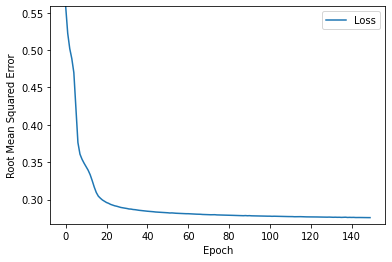

In [ ]:
plot_the_loss_curve(epochs, rmse)

["Length", "GCpercent","CGratio", "AUratio", "MFE", "AA","AU","AG","AC","UA","UU","UG","UC","GA","GU","GG","GC","CA","CU","CG", "CC"]

Plot Results for Mean MFE prediction

In [ ]:
meanMFE_result = my_model.predict(training_df[["Length", "GCpercent","CGratio", "AUratio", 'AA', 'AU', 'AG',
      'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG', 'CC']])

In [ ]:
predicted_mfes.describe()
#meanMFE_result = my_model.predict(training_df[["Length", "GCpercent","CGratio", "AUratio", 'MFE']])
#meanMFE_result = my_model.predict(training_df[["Length", "GCpercent", "MFE"]])
predicted_mfes = pd.DataFrame(meanMFE_result)
#predicted_mfes.columns = ["predictedMonoMFEs"]
#predicted_mfes = predicted_mfes.rename(columns={0:"PredictedDiMFE"})
#predicted_mfes["MonoMFE"] = my_label
#predicted_mfes["DiMFE"] = my_label
#predicted_mfes["predictedMonoMFEs"] = predicted_mfes
#predicted_mfes["DiMFE"] = predicted_mfes
predicted_mfes["MFE"] = loaded_df['MFE'].to_list()
predicted_mfes["RealDiMFE"] = loaded_df['DiMFE'].to_list()
predicted_mfes.plot.scatter(x="DiMFE", y="PredictedDiMFE")

-OR- Plot results for standard deviation prediction

In [ ]:

DiStd_result = my_model.predict(training_df[["Length", "GCpercent","CGratio", "AUratio", 'AA', 'AU', 'AG',
      'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG', 'CC']])
predicted_std = pd.DataFrame(DiStd_result)



In [ ]:
predicted_std.columns = ["predictedDiStd"]
predicted_std["DiStd"] = loaded_df['DiStd'].to_list()
# predicted_std["RealDiMFE"] = loaded_df['DiMFE'].to_list()


ValueError: ignored

In [ ]:
predicted_std.describe()

,predictedDiStd,DiStd
count,836376.0,836376.0
mean,3.3,3.4
std,0.6,0.6
min,0.1,0.0
25%,3.0,3.0
50%,3.4,3.4
75%,3.8,3.9
max,4.7,6.0


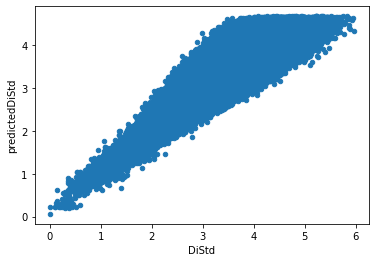

In [ ]:
predicted_std.plot.scatter(x="DiStd", y="predictedDiStd")


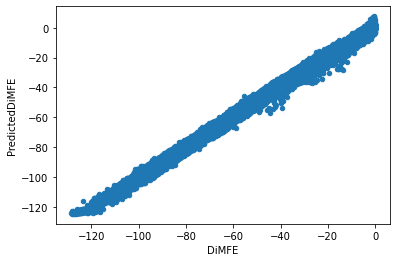

KeyError: ignored

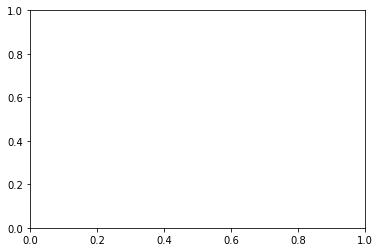

In [ ]:
predicted_mfes.plot.scatter(x="predictedMonoMFEs", y='MFE')

In [ ]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 20)               41        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                1344      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,610
Trainable params: 5,569
Non-trainable params: 41
_________________________________________________________________


# Making Predictions with model

## Installing ViennaRNA

In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
!conda install -c bioconda -y viennarna

In [ ]:
#import RNA

In [ ]:
import subprocess
def rna_fold_rnafold(frag, temperature):
    args = ["RNAfold", "-p", "-T", str(temperature)]
    fc = subprocess.run(args, input=str(frag), check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out = str(fc.stdout)
    test = out.splitlines()
    structure = test[1].split()[0]
    centroid = test[3].split()[0]
    MFE = test[1].split(" ", 1)[1]
    try:
        MFE = float(re.sub('[()]', '', MFE))
    except:
        print("Error parsing MFE values", test)
    ED = float(test[4].split()[-1])

    return (structure, centroid, MFE, ED)

## Making predictions

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use



In [ ]:
frag = "GCUGAGGCUUCUAAGAAGCCUCGGCAAAAACGUACUGCCACUAAAGCAUACAAUGUAACACAAGCUUUCGGCAGACGUGGUCCAGAACAAACCCAAGGAAAUUUUGGGGACCAGGAACUA"
frag = frag.replace("T", "U")
GCpercent = get_gc_content(frag)
CGratio = get_cg_ratio(frag)
AUratio = get_au_ratio(frag)
di_freqs = get_di_freqs(frag)

structure, centroid, MFE, ED = rna_fold_rnafold(frag, 37)

frag_features = [float(len(frag)), float(GCpercent), float(CGratio), float(AUratio)]
#for freq in di_freqs:
#  frag_features.append(freq)
#frag_features = tf.convert_to_tensor(frag_features)
#frag_features.reshape(frag_features, (20,))
frag_predict = pd.DataFrame(frag_features).transpose()
frag_predict.columns = ["Length", "GCpercent","CGratio", "AUratio"]
dfeval = frag_predict
#y_eval = pd.DataFrame([-95])
#eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)
dfeval.shape
print(dfeval)
result = my_model.predict(dfeval)

predicted_MFE = result[0][0]
MFE = MFE.replace(")", "")
MFE = MFE.replace("(", "")
print(predicted_MFE, float(MFE))

Now we can save the model. 

In [ ]:
folder_name = "set/path/of/model/folder"
tf.keras.models.save_model(my_model, folder_name)

INFO:tensorflow:Assets written to: /content/drive/My Drive/DiStd/assets


# Testing model on RNAcentral data

In [ ]:
test_df.describe()

In [ ]:
test_over_60 = test_df[test_df['Length'] >= 60]

In [ ]:
test_over_60.apply(pd.to_numeric)


In [ ]:
test_over_60.describe()

In [ ]:
my_feature.columns

In [ ]:
# meanMFE_result = my_model.predict(test_df[["length", "GC%","CGratio", "AUratio", "MFE", 'AA', 'AU', 'AG',
#       'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG',
#        'CC']])
#meanMFE_result = my_model.predict(test_df[["length", "GC%", "MFE"]])

### Run 3
# meanMFE_result = Run3_meanMFE.predict(test_over_60[["length", "GC%","CGratio", "AUratio", 'AA', 'AU', 'AG',
#      'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG',
#       'CC']])
### Four features:
#meanMFE_result = my_model.predict(test_over_60[["length", "GC%", "CGratio", "AUratio"]])

# ### Full feature:
# rna_central_MonoMFE_result = Run3_meanMFE.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio", 'AA', 'AU', 'AG',
#       'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG',
#        'CC']])


### Full feature AND native MFE:
rna_central_MonoMFE_result = Run3_MonoMFE.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio", 'MFE', 'AA', 'AU', 'AG',
      'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG',
       'CC']])

#rna_central_MonoStd_result = StdDevModel.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio"]])


In [ ]:
# ### Full feature Std predict:
# rna_central_MonoStd_result = Run3_MonoStd.predict(test_df[["Length", "GCpercent","CGratio", "AUratio", 'AA', 'AU', 'AG',
#       'AC', 'UA', 'UU', 'UG', 'UC', 'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG',
#        'CC']])

### 4 feature mean MFE model
# rna_central_MonoMFE_result = MeanMFEmodel.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio"]])
# rna_central_MonoStd_result = StdDevModel.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio"]])

### 5 Feature Mean MFE models
#rna_central_MonoMFE_result = five_variable_meanMFEmodel.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio", "MFE"]])
rna_central_MonoStd_result = five_variable_stddevMFEmodel.predict(test_over_60[["Length", "GCpercent","CGratio", "AUratio", "MFE"]])

### Three feature model
#rna_central_MonoMFE_result = my_model.predict(test_over_60[["Length", "GCpercent", 'MFE']])

### Two Feature Model 
rna_central_MonoMFE_result = my_model.predict(test_over_60[["Length", "GCpercent"]])


In [ ]:
rna_central_predicted_mfes = []
#rna_central_predicted_stds = pd.DataFrame(rna_central_MonoStd_result)
rna_central_predicted_mfes = pd.DataFrame(rna_central_MonoMFE_result)

In [ ]:
#rna_central_predicted_stds = pd.DataFrame(rna_central_MonoStd_result)
#rna_central_predicted_mfes.columns = ["predictedMonoStds"]
rna_central_predicted_mfes["predictedMonoStds"] = rna_central_MonoStd_result
rna_central_predicted_mfes["predictedMonoMFEs"] = rna_central_MonoMFE_result

In [ ]:
len(test_over_60['MFE'])

In [ ]:
rna_central_predicted_mfes["MFE"] = test_over_60['MFE'].to_list()
rna_central_predicted_mfes["Length"] = test_over_60['Length'].to_list()
rna_central_predicted_mfes["MonoMFE"] = test_over_60['MonoMFE'].to_list()
rna_central_predicted_mfes["DiMFE"] = test_over_60['DiMFE'].to_list()

#predicted_mfes["DiMFE"] = di_mfe


In [ ]:
rna_central_predicted_mfes.describe()

In [ ]:
my_label.describe()

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="predictedMonoMFEs", y='MonoMFE')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="predictedMonoMFEs", y='MonoMFE')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="predictedMonoMFEs", y='MFE')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="predictedMonoMFEs", y='MFE')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="MonoMFE", y='MFE')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="DiMFE", y='MFE')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="MonoMFE", y='DiMFE')

Calculating z-scores

In [ ]:
### Create MFE list
mfe_list = test_over_60['MFE'].tolist()

In [ ]:
zscore_list = []
for i in range(0, len(mfe_list)):
    mfe = (mfe_list[i])
    print(mfe)
    mean_mfe = rna_central_meanMFE_result[i][0]
    print(mean_mfe)
    std = rna_central_MonoStd_result[i][0]
    print(std)
    if mean_mfe > 0:
      #print(mean_mfe)
      mean_mfe = 0
    zscore = round(float((mfe-mean_mfe)/std), 2)
    zscore_list.append(zscore)

In [ ]:
len(zscore_list)

In [ ]:
rna_central_predicted_mfes['predicted_Z-scores'] = zscore_list

In [ ]:
rna_central_predicted_mfes['Mono_Z-scores'] = test_over_60['mono_z'].to_list()


In [ ]:
rna_central_predicted_mfes['Di_Z-scores'] = test_over_60['di_z'].to_list()


In [ ]:
#rna_central_predicted_mfes.plot.scatter(x="predicted_Z-scores", y='Mono_Z-scores', xlim=[-10, 10], ylim=[-10,10])
rna_central_predicted_mfes.plot.scatter(x="predicted_Z-scores", y='Mono_Z-scores')

In [ ]:
rna_central_predicted_mfes.plot.scatter(x="predicted_Z-scores", y='Di_Z-scores', xlim=[-20, 10])

Violin Plot

In [ ]:
fig, axes = plt.subplots()

axes.violinplot(dataset = test_df[test_df['MonoMFE'].values])

axes.set_title('Predicted Mono MFEs')
axes.set_xlabel('Predicted Mono MFE')

plt.show()

### Questions or suggestions?
E-mail:

Ryan J. Andrews ryan.j.rna@gmail.com
Walter N. Moss wmoss@iastate.edu
Warren B. Rouse wbrouse@iastate.edu

